In [2]:
import sys
sys.path.append("../DeepHypergraph/") 

In [3]:
import time
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

from dhg import Hypergraph
from dhg.data import DBLP8k
from dhg.models import HGNNPLinkPred
from dhg.random import set_seed
from dhg.metrics import LinkPredictionEvaluator as Evaluator

In [4]:
def train(net, X, hypergraph, negative_hypergraph, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    pos_score = net(X, hypergraph)
    neg_score = net(X, negative_hypergraph)

    global device
    scores = torch.cat([pos_score, neg_score]).squeeze()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).to(device)

    loss = F.binary_cross_entropy_with_logits(scores, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()

In [5]:
@torch.no_grad()
def infer(net, X, hypergraph, negative_hypergraph, test=False):
    net.eval()
    pos_score = net(X, hypergraph)
    neg_score = net(X, negative_hypergraph)

    scores = torch.cat([pos_score, neg_score]).squeeze()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).to(device)

    global evaluator
    if not test:
        res = evaluator.validate(labels, scores)
    else:
        res = evaluator.test(labels, scores)
    return res

In [6]:
import csv
from pathlib import Path

def load_data(file_path: Path):
    hyperedge_list = []
    neg_hyperedge_list = []
    with open(file_path / "hyperedges.csv", "r") as file:
        reader = csv.reader(file)
        for row in reader:
            # 读取每个超边的顶点列表，并将它们添加到 hyperedge_list 中
            hyperedge_list.append(row)
    
    hyperedge_list = [[int(v) for v in edge] for edge in hyperedge_list]

    with open(file_path / "minimal_unschedulable_combinations.csv", "r") as file:
        reader = csv.reader(file)
        for row in reader:
            neg_hyperedge_list.append(row) 

    neg_hyperedge_list = [[int(v) for v in edge] for edge in neg_hyperedge_list]

    with open(file_path / "task_quadruples.csv", 'r') as csvfile:
        reader = csv.reader(csvfile)
        data = [list(map(float, row)) for row in reader]

    # 将数据转换为 Tensor
    features = torch.tensor(data)

    data = {"hyperedge_list": hyperedge_list, "num_edges" : len(hyperedge_list)}
    neg_data = {"hyperedge_list": neg_hyperedge_list, "num_edges" : len(neg_hyperedge_list)}

    return {"pos":data, "neg": neg_data, "vertices_feature" : features, "num_vertices" : features.shape[0]}

In [7]:
set_seed(2021)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "auc", "f1_score"])
train_data =    load_data(Path("../EDF/data/data_s3000_p3_t1000_hs7_e10000/"))
validate_data = load_data(Path("../EDF/data/data_s3001_p3_t1000_hs7_e10000/"))
test_data =     load_data(Path("../EDF/data/data_s3002_p3_t1000_hs7_e10000/"))

X = train_data["vertices_feature"]
HG = Hypergraph(train_data["num_vertices"], train_data["pos"]["hyperedge_list"])
neg_HG = Hypergraph(train_data["num_vertices"], train_data["neg"]["hyperedge_list"])

validate_X = validate_data["vertices_feature"]
validate_HG = Hypergraph(validate_data["num_vertices"], validate_data["pos"]["hyperedge_list"])
validate_neg_HG = Hypergraph(validate_data["num_vertices"], validate_data["neg"]["hyperedge_list"])

test_X = test_data["vertices_feature"]
test_HG = Hypergraph(test_data["num_vertices"], test_data["pos"]["hyperedge_list"])
test_neg_HG = Hypergraph(test_data["num_vertices"], test_data["neg"]["hyperedge_list"])

In [8]:
import numpy as np

def calculate_sparsity(matrix):
    nonzero_elements = np.count_nonzero(matrix)
    total_elements = matrix.size

    nonzero_ratio = nonzero_elements / total_elements
    zero_ratio = 1 - nonzero_ratio

    print(f"非零元素比例：{nonzero_ratio:.2%}")
    print(f"零元素比例：{zero_ratio:.2%}")

calculate_sparsity(HG.H.to_dense().cpu().numpy())

非零元素比例：0.30%
零元素比例：99.70%


In [12]:
degree_values = test_HG.deg_v
print(degree_values)
print(degree_values[489])

[897.0, 903.0, 785.0, 810.0, 870.0, 468.0, 979.0, 1005.0, 777.0, 993.0, 858.0, 807.0, 925.0, 829.0, 923.0, 827.0, 977.0, 919.0, 754.0, 913.0, 763.0, 878.0, 878.0, 952.0, 920.0, 772.0, 541.0, 809.0, 171.0, 740.0, 971.0, 760.0, 766.0, 872.0, 704.0, 790.0, 705.0, 723.0, 960.0, 923.0, 762.0, 924.0, 704.0, 973.0, 847.0, 579.0, 772.0, 630.0, 747.0, 943.0, 902.0, 962.0, 770.0, 691.0, 881.0, 866.0, 853.0, 702.0, 816.0, 892.0, 870.0, 682.0, 879.0, 801.0, 832.0, 699.0, 985.0, 769.0, 884.0, 1025.0, 835.0, 787.0, 759.0, 673.0, 1029.0, 941.0, 176.0, 706.0, 605.0, 770.0, 724.0, 852.0, 742.0, 713.0, 763.0, 809.0, 717.0, 827.0, 835.0, 716.0, 691.0, 751.0, 663.0, 897.0, 846.0, 199.0, 803.0, 835.0, 804.0, 749.0, 663.0, 736.0, 770.0, 777.0, 672.0, 677.0, 854.0, 676.0, 837.0, 910.0, 644.0, 775.0, 990.0, 492.0, 819.0, 204.0, 657.0, 823.0, 580.0, 686.0, 643.0, 731.0, 762.0, 625.0, 838.0, 876.0, 817.0, 731.0, 776.0, 749.0, 794.0, 869.0, 819.0, 752.0, 714.0, 708.0, 515.0, 883.0, 708.0, 807.0, 751.0, 233.0, 89

In [9]:
import matplotlib.pyplot as plt

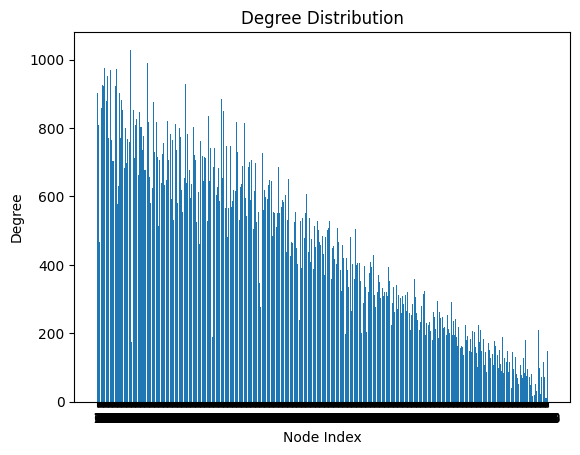

In [18]:
# 绘制节点度数的柱状图
plt.bar(range(len(degree_values)), degree_values)
plt.xticks(range(len(degree_values)), range(len(degree_values)))
plt.xlabel('Node Index')
plt.ylabel('Degree')
plt.title('Degree Distribution')
plt.show()